#### Importing required libraries

In [7]:
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import shutil
from sklearn.model_selection import train_test_split

##### EXTRA: GPU Part of Code

In [2]:
print(tf.__version__)
tf.test.is_gpu_available()

2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

##### EXTRA: Clearing GPU Memory

In [25]:
import gc
tf.keras.backend.clear_session()
gc.collect()

105

##### EXTRA: Clear Keras Session

In [ ]:
from keras import backend as K
K.clear_session()

##### EXTRA: Mixed Precision (float16 instead of float32

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

##### EXTRA: Gradient Checkpointing

In [ ]:
import tensorflow as tf
tf.config.experimental.enable_tensor_float_32_execution(False)

##### EXTRA: GPU Memory Upgrade

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

#### Creation of directories

##### Paths to original dataset

In [9]:
base_dir = 'Infrared Data'
train_dir = os.path.join(base_dir, 'train')
image_dir = os.path.join(train_dir, 'images')
mask_dir = os.path.join(train_dir, 'masks')

##### New directories for train and test

In [12]:
new_train_dir = os.path.join(base_dir, 'train_new')
new_test_dir = os.path.join(base_dir, 'test_new')

##### Creating new train and test directories

In [15]:
for split in [new_train_dir, new_test_dir]:
    os.makedirs(os.path.join(split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split, 'masks'), exist_ok=True)

##### Getting list of images and masks

In [17]:
os.chdir("/Users/sibikarthik/OIL_SPILL_DETECTION/")

In [19]:
image_filenames = sorted(os.listdir(image_dir))
mask_filenames = sorted(os.listdir(mask_dir))

##### Ensuring image-mask correspondence

In [22]:
print(len(image_filenames))
print(len(mask_filenames))
assert len(image_filenames) == len(mask_filenames), "Mismatch in image and mask counts"

2077
2077


##### Split dataset (80% train, 20% test)

In [25]:
train_images, test_images, train_masks, test_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

##### Helper function to copy files

In [28]:
def copy_files(files, src_folder, dest_folder):
    for file in files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

##### Copying images and masks to new train and test directories

In [13]:
copy_files(train_images, image_dir, os.path.join(new_train_dir, 'images'))
copy_files(train_masks, mask_dir, os.path.join(new_train_dir, 'masks'))
copy_files(test_images, image_dir, os.path.join(new_test_dir, 'images'))
copy_files(test_masks, mask_dir, os.path.join(new_test_dir, 'masks'))

In [31]:
print(f"Dataset split complete:")
print(f"Train set: {len(train_images)} images, {len(train_masks)} masks")
print(f"Test set: {len(test_images)} images, {len(test_masks)} masks")

Dataset split complete:
Train set: 1661 images, 1661 masks
Test set: 416 images, 416 masks


#### Data Preprocessing and Dataset Initiation

##### Loading and preprocessing images and masks

In [35]:
def load_image_mask(img_path, mask_path, target_size=(256, 256)):
    # Load and decode image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1)  # Ensure grayscale (1 channel)
    image = tf.image.resize(image, target_size)

    # Normalize image to [0, 1] for better training stability
    image = tf.cast(image, tf.float32) / 255.0

    # Load and decode mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Ensure 1 channel for masks
    mask = tf.image.resize(mask, target_size)

    # Ensure mask values are 0 or 1 (binary mask)
    mask = tf.cast(mask > 0, tf.float32)  

    return image, mask

##### Data augmentation

In [38]:
def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (0°, 90°, 180°, 270°)
    angle = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=angle)
    mask = tf.image.rot90(mask, k=angle)

    # Random brightness adjustment (for image only)
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Ensure size remains constant
    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))

    return image, mask

##### Creating dataset with augmentation

In [51]:
def create_dataset(image_dir, mask_dir, target_size=(256, 256), augment_data=False):
    # Filter only image files and ignore hidden files/folders like .ipynb_checkpoints
    valid_extensions = ('.png', '.jpg', '.jpeg')

    images = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith(valid_extensions) and os.path.isfile(os.path.join(image_dir, f))
    ])
    
    masks = sorted([
        f for f in os.listdir(mask_dir)
        if f.lower().endswith(valid_extensions) and os.path.isfile(os.path.join(mask_dir, f))
    ])

    X, Y = [], []
    for img_name, mask_name in zip(images, masks):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        image, mask = load_image_mask(img_path, mask_path, target_size)

        if augment_data:
            image, mask = augment(image, mask)

        X.append(image)
        Y.append(mask)

    return np.array(X), np.array(Y)

##### Setting paths

In [54]:
train_image_dir = 'Infrared Data/train_new/images'
train_mask_dir = 'Infrared Data/train_new/masks'
test_image_dir = 'Infrared Data/test_new/images'
test_mask_dir = 'Infrared Data/test_new/masks'

##### Loading datasets (with augmentation for training data only)

In [57]:
X_train, Y_train = create_dataset(train_image_dir, train_mask_dir, augment_data=True)
X_test, Y_test = create_dataset(test_image_dir, test_mask_dir, augment_data=False)

print(f"Training data: {X_train.shape}, {Y_train.shape}")
print(f"Testing data: {X_test.shape}, {Y_test.shape}")

Training data: (1661, 256, 256, 1), (1661, 256, 256, 1)
Testing data: (416, 256, 256, 1), (416, 256, 256, 1)


#### DeepLabv3 Model Architecture (Compilation and Training)

In [49]:
def build_deeplabv3(input_shape=(256, 256, 1), num_classes=1):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    
    # Convert grayscale to 3-channel input for ResNet compatibility
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(3, (1, 1), activation='relu')(inputs)
    
    # Extract features using ResNet backbone
    x = base_model(x, training=False)
    
    # ASPP Module (Atrous Spatial Pyramid Pooling)
    b1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    b2 = layers.Conv2D(256, 3, padding="same", dilation_rate=6, activation="relu")(x)
    b3 = layers.Conv2D(256, 3, padding="same", dilation_rate=12, activation="relu")(x)
    b4 = layers.Conv2D(256, 3, padding="same", dilation_rate=18, activation="relu")(x)
    
    # Global Average Pooling
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1, 1, -1))(pool)
    pool = layers.Conv2D(256, 1, padding="same", activation="relu")(pool)
    pool = layers.UpSampling2D(size=(256 // 32, 256 // 32), interpolation="bilinear")(pool)
    
    # Concatenate ASPP outputs
    x = layers.Concatenate()([b1, b2, b3, b4, pool])
    x = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    
    # Upsampling to (256, 256)
    x = layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(x)  # 8x8 → 64x64
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)  # 64x64 → 256x256

    # Output segmentation map
    outputs = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

deeplabv3_model = build_deeplabv3()
deeplabv3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 3)  6           ['input_2[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['conv2d[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']           

##### Model plotting

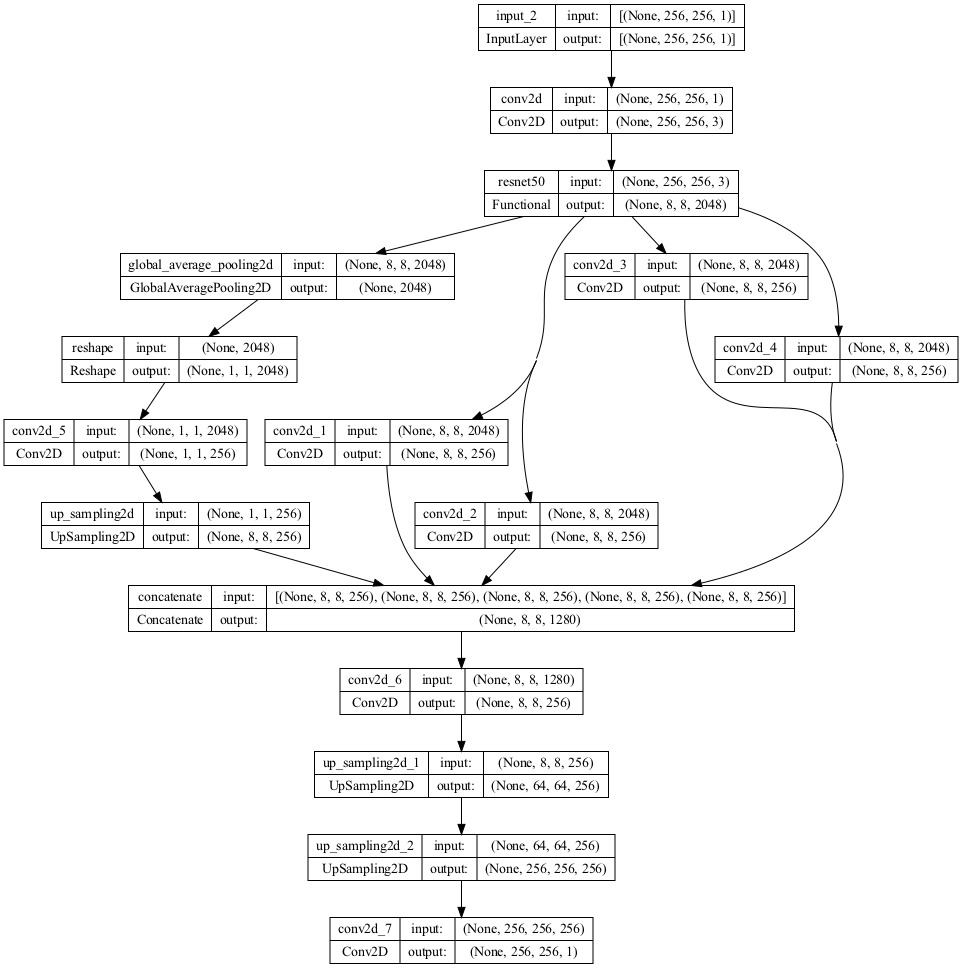

In [45]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

#unet_model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
tf.keras.utils.plot_model(deeplabv3_model, show_shapes=True, dpi=72)

##### Compiling the model

In [22]:
deeplabv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##### Saving the best model during training

In [23]:
checkpoint = ModelCheckpoint('deeplabv3_infrared_oilspill.h5', save_best_only=True, monitor='val_loss')

##### Training the model

In [26]:
deeplabv3 = deeplabv3_model.fit(
    X_train, Y_train,
    epochs=25,
    batch_size=4,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint]
)

Epoch 1/25
416/416 [==============================] - 60s 105ms/step - loss: 0.7383 - accuracy: 0.7600 - val_loss: 0.5188 - val_accuracy: 0.7629
Epoch 2/25
416/416 [==============================] - 40s 96ms/step - loss: 0.5161 - accuracy: 0.7646 - val_loss: 0.5113 - val_accuracy: 0.7671
Epoch 3/25
416/416 [==============================] - 41s 99ms/step - loss: 0.5129 - accuracy: 0.7657 - val_loss: 0.4985 - val_accuracy: 0.7642
Epoch 4/25
416/416 [==============================] - 41s 97ms/step - loss: 0.5142 - accuracy: 0.7650 - val_loss: 0.5384 - val_accuracy: 0.7621
Epoch 5/25
416/416 [==============================] - 37s 89ms/step - loss: 0.5120 - accuracy: 0.7660 - val_loss: 0.5164 - val_accuracy: 0.7666
Epoch 6/25
416/416 [==============================] - 38s 90ms/step - loss: 0.5117 - accuracy: 0.7660 - val_loss: 0.5097 - val_accuracy: 0.7666
Epoch 7/25
416/416 [==============================] - 38s 92ms/step - loss: 0.5113 - accuracy: 0.7665 - val_loss: 0.5087 - val_accuracy

#### Saving

##### Model

In [27]:
deeplabv3_model.save("infrared_deeplabv3.keras")
deeplabv3_model.save("infrared_deeplabv3.h5")

##### Training History

In [28]:
    import pickle
    with open("history_infrared_deeplabv3.pkl", "wb") as f:
        pickle.dump(deeplabv3.history, f)
    print("Model and history saved!")

Model and history saved!


#### Loading

##### Model

In [51]:
os.getcwd()

'/Users/sibikarthik/OIL_SPILL_DETECTION'

In [60]:
from tensorflow.keras.models import load_model
deeplabv3_model = load_model("/Users/sibikarthik/OIL_SPILL_DETECTION/3) Infrared DeepLabv3/infrared.keras")

##### Training History

In [62]:
import pickle
with open("/Users/sibikarthik/OIL_SPILL_DETECTION/3) Infrared DeepLabv3/history_infrared.pkl", "rb") as f:
    deeplabv3 = pickle.load(f)
print("Model and history restored!")

Model and history restored!


#### Model Metrics

##### Plotting training history

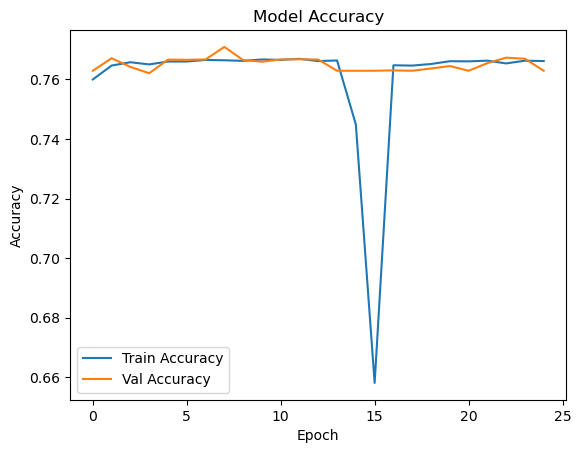

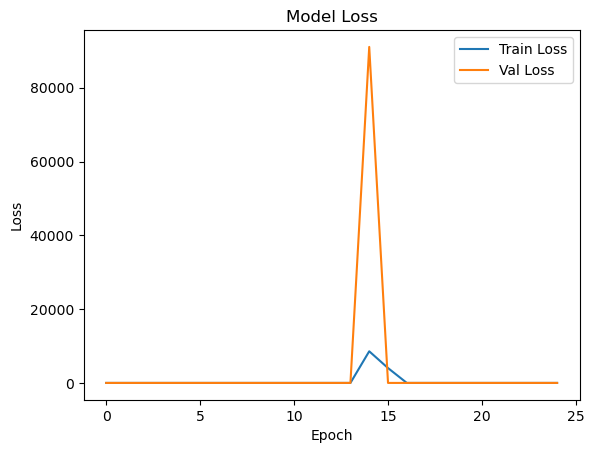

In [67]:
plt.plot(deeplabv3['accuracy'], label='Train Accuracy')
plt.plot(deeplabv3['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(deeplabv3['loss'], label='Train Loss')
plt.plot(deeplabv3['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Model Assessment

#### Evaluating model on test data

In [71]:
loss, acc = deeplabv3_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc:.4f}")

13/13 [==============================] - 70s 5s/step - loss: 0.5060 - accuracy: 0.7629
Test Accuracy: 0.7629


##### Prediction on a sample image

In [74]:
sample_image = X_test[25:26]
predicted_mask = deeplabv3_model.predict(sample_image)

1/1 [==============================] - 1s 963ms/step


##### Displaying original image, ground truth, and predicted mask

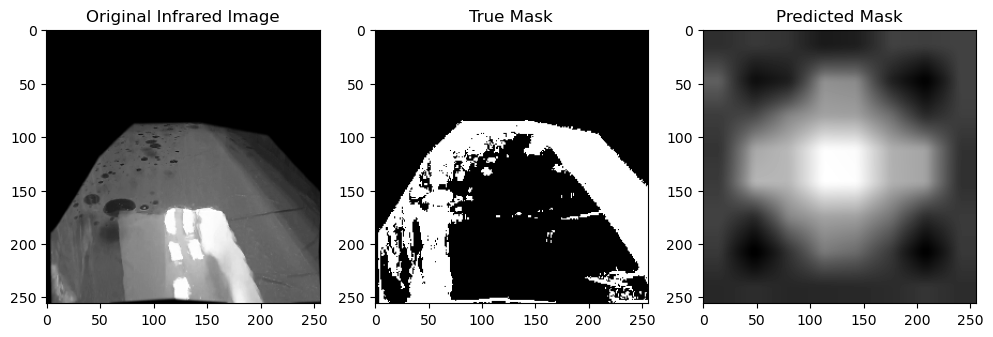

In [81]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Infrared Image')
plt.imshow(sample_image[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title('True Mask')
plt.imshow(Y_test[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
predicted__mask = (predicted_mask > 0.5).astype(np.uint8)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')

plt.show()

##### Confusion matrix, precision, recall, and F1 score

In [110]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define directories
test_images_dir = "/Users/sibikarthik/OIL_SPILL_DETECTION/Infrared Data/test_new/images"
test_masks_dir = "/Users/sibikarthik/OIL_SPILL_DETECTION/Infrared Data/test_new/masks"

# Get list of image files
test_image_files = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png') or f.endswith('.jpg')])
test_mask_files = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir) if f.endswith('.png') or f.endswith('.jpg')])

# Load images and masks into arrays
test_images = np.array([img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0 for img_path in test_image_files])
test_masks = np.array([img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0 for mask_path in test_mask_files])

# Reshape masks to match model's expected output
test_masks = test_masks.squeeze()  # Remove extra channel if necessary

print(f"Loaded {len(test_images)} test images.")
print(f"Loaded {len(test_masks)} test masks.")

Loaded 416 test images.
Loaded 416 test masks.


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Generate predictions
prediction = deeplabv3_model.predict(test_images)

# Print shapes to verify alignment
print(f"Test Masks Shape: {test_masks.shape}")
print(f"Prediction Shape: {prediction.shape}")

# Flatten arrays for evaluation
deeplabv3_true_labels = (test_masks.flatten() > 0.5).astype(np.uint8)
deeplabv3_predicted_labels = (prediction.flatten() > 0.5).astype(np.uint8)

# Compute confusion matrix
cm = confusion_matrix(deeplabv3_true_labels, deeplabv3_predicted_labels)

# Print confusion matrix values for verification
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spill', 'Oil Spill'], yticklabels=['No Spill', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Oil Spill Detection')
plt.show()

# Compute precision, recall, and F1-score
precision = precision_score(deeplabv3_true_labels, deeplabv3_predicted_labels, average='binary', zero_division=1)
recall = recall_score(deeplabv3_true_labels, deeplabv3_predicted_labels, average='binary', zero_division=1)
f1 = f1_score(deeplabv3_true_labels, deeplabv3_predicted_labels, average='binary', zero_division=1)

# Display metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

2025-04-08 23:29:50.091007: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: Fused conv implementation does not support grouped convolutions for now.
	 [[{{node model/conv2d/Relu}}]]


UnimplementedError: Graph execution error:

Detected at node 'model/conv2d/Relu' defined at (most recent call last):
    File "/Applications/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/Applications/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/Applications/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Applications/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Applications/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Applications/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/Applications/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/b1/nb_549714h9c28550y1_1n280000gq/T/ipykernel_24111/3804836394.py", line 7, in <module>
      prediction = deeplabv3_model.predict(test_images)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/Applications/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node model/conv2d/Relu}}]] [Op:__inference_predict_function_175282]

#### Density Map Calculation

##### Saving the predicted intensity map and calculating the density

In [ ]:
def save_intensity_map_and_density(predicted_mask, save_path='intensity_map.png'):
    # Convert predicted mask to 8-bit (0-255 range)
    mask = (predicted_mask * 255).astype(np.uint8)

    # Apply color map for visualization
    colored_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    cv2.imwrite(save_path, colored_mask)
    print(f"Intensity map saved as '{save_path}'")

    # Calculate density of oil spill
    total_pixels = mask.size
    spill_pixels = np.sum(mask > 50)  # Count pixels with oil presence (threshold = 50 for spill)
    spill_density = (spill_pixels / total_pixels) * 100

    print(f"Oil Spill Density: {spill_density:.2f}%")

    return spill_density

##### Calculating density and saving intensity map

In [ ]:
density = save_intensity_map_and_density(predicted_mask[0, :, :, 0])
print(f"Oil Spill Density: {density:.2f}%")

#####

# Infrared Complete

In [ ]:
# ------------------------------
# 1. IMPORT LIBRARIES
# ------------------------------

import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from segmentation_models import DeepLabV3Plus
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow.keras.optimizers import Adam
import albumentations as A
from albumentations.core.composition import OneOf

# ------------------------------
# 2. DATA LOADING AND PREPROCESSING
# ------------------------------

# Set paths
IMAGE_DIR = '/path/to/infrared_images/'     # Path to infrared images
MASK_DIR = '/path/to/masks/'                # Path to ground truth masks

# Load images and masks
image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

images = [cv2.imread(os.path.join(IMAGE_DIR, f)) for f in image_filenames]
masks = [cv2.imread(os.path.join(MASK_DIR, f), cv2.IMREAD_GRAYSCALE) for f in mask_filenames]

# Normalize images and masks
images = np.array([cv2.resize(img, (256, 256)) / 255.0 for img in images])
masks = np.array([cv2.resize(mask, (256, 256)) / 255.0 for mask in masks])

# Expand mask dimensions for model compatibility
masks = np.expand_dims(masks, axis=-1)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# ------------------------------
# 3. DATA AUGMENTATION
# ------------------------------

# Albumentations augmentation for training data
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.5),
        A.CLAHE(p=0.5)
    ], p=0.8),
    A.Rotate(limit=30, p=0.5)
])

# Augment training images and masks
def augment_data(images, masks):
    aug_images, aug_masks = [], []
    for img, mask in zip(images, masks):
        augmented = augmentor(image=img, mask=mask)
        aug_images.append(augmented['image'])
        aug_masks.append(augmented['mask'])
    return np.array(aug_images), np.array(aug_masks)

X_train_aug, y_train_aug = augment_data(X_train, y_train)

# ------------------------------
# 4. MODEL DEFINITION (DEEPLABV3+)
# ------------------------------

BACKBONE = 'resnet34'  # Pretrained backbone
model = DeepLabV3Plus(BACKBONE, input_shape=(256, 256, 3), classes=1, activation='sigmoid')
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=DiceLoss(),
    metrics=[iou_score, f1_score]
)

# ------------------------------
# 5. TRAINING
# ------------------------------

BATCH_SIZE = 16
EPOCHS = 50

history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# ------------------------------
# 6. PREDICTION AND VISUALIZATION
# ------------------------------

def plot_predictions(image, true_mask, pred_mask):
    """
    Plots the original image, true mask, and predicted mask.
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Infrared Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Choose a random image from the test set
idx = np.random.randint(len(X_test))
test_img = np.expand_dims(X_test[idx], axis=0)
true_mask = y_test[idx]

# Prediction
pred_mask = model.predict(test_img)[0]

# Binarize the mask
threshold = 0.5
pred_mask_bin = (pred_mask > threshold).astype(np.uint8)

# Display results
plot_predictions(X_test[idx], true_mask, pred_mask_bin)

# ------------------------------
# 7. INTENSITY-BASED ANALYSIS
# ------------------------------

def calculate_intensity(mask):
    """
    Calculates mean intensity and standard deviation of the mask.
    """
    mean_intensity = np.mean(mask)
    std_dev = np.std(mask)
    
    # Severity classification
    if mean_intensity < 0.2:
        severity = "Low"
    elif mean_intensity < 0.5:
        severity = "Moderate"
    else:
        severity = "High"

    return mean_intensity, std_dev, severity

# Intensity metrics
mean_intensity, std_dev, severity = calculate_intensity(pred_mask_bin)

print(f"\n🔥 Spill Analysis 🔥")
print(f"Mean Intensity: {mean_intensity:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Severity: {severity}")

# ------------------------------
# 8. EVALUATION METRICS
# ------------------------------
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on test data.
    """
    results = model.evaluate(X_test, y_test, batch_size=16)
    loss, iou, dice = results

    print("\n📊 **Evaluation Metrics**")
    print(f"Loss: {loss:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

evaluate_model(model, X_test, y_test)